In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

In [2]:

import json
import pandas as pd
from twitter import *

import sys
import time


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 3.2 MB/s 


In [ ]:
from twitter.api import TwitterHTTPError
from urllib.error import URLError
from http.client import BadStatusLine

from functools import partial

from sys import maxsize
import tweepy

In [3]:
# Credentials for the API

bearerToken = "AAAAAAAAAAAAAAAAAAAAAG5YfgEAAAAA76uRa23UrTTLBLR8%2FS51mo7Tj1o%3DuZihLLkXct1A2oDOCf6GH1G15p8C7odnSLciTdqBjH7EaODrVR"
api_key = "XRt3DZEZQBqLYxb7w5JCjxFdm"
api_key_secret = "aBcD4zpMdSKQkncx3Y0l7CQiOJ3IitRtIWUQojOS4hWvrqYu2x"
access_token = "1473981724149239809-VKghKWIIDKabUY51XW7lbAL2vQyZJk"
access_token_secret = "wlU6OKaLESrRsIqaieHXEVnNU9v4ktS7oZheNp2hFzDSJ"
auth = OAuth(access_token, access_token_secret,api_key, api_key_secret)

t = Twitter(auth=auth)


In [4]:
# User interested
popular_user =  'imVkohli'

In [6]:
def get_ids_friends_followers(twitter_api, screen_name=None, user_id=None,
                                friends_limit=maxsize, followers_limit=maxsize):
    
    
    # You can also do this with a function closure.
    get_friends_ids = partial(make_twitter_requests, twitter_api.friends.ids,count=5000)
    
    get_followers_ids = partial(make_twitter_requests, twitter_api.followers.ids,count=5000)
    
    friends_ids = []
    followers_ids = []
    # API to store the friends_followers_ids
    for twitter_api_func, limit, ids, label in [
            [get_friends_ids, friends_limit, friends_ids, "friends"],
            [get_followers_ids, followers_limit, followers_ids, "followers"]
            ]:
        
       
        if limit == 0: 
            continue
        
        cursor = -1
        while cursor != 0: 
            
            # Use make_twitter_request via the partially bound callable...
            if screen_name:
                response = twitter_api_func(screen_name=screen_name, cursor=cursor)
            else: # user_id
                response = twitter_api_func(user_id=user_id, cursor=cursor)
                
            if response is not None:
                ids += response['ids']
                cursor = response['next_cursor']
                
           
            
            if len(ids) >= limit or response is None:
                break
                
    
    return friends_ids[:friends_limit], followers_ids[:followers_limit]

In [5]:
def make_twitter_requests(twitter_api_func, max_errors=10, *args, **kw):
    # A function that handles rate limit(429 error) and waits for 15 minutes to
    # reset. Returns None for 401 and 404 errors, which requires special handling
    def handle_twitter_http_error(e, wait_period=2, sleep_when_rate_limited=True):
        
        if wait_period > 3600: # Seconds
            print('Too many retries. Quitting.', file=sys.stderr)
            raise e        
        
        
        if e.e.code == 401:
            print('Encountered 401 Error (Not Authorized)', file=sys.stderr)
            return None
        elif e.e.code == 404:
            print('Encountered 404 Error (Not Found)', file=sys.stderr)
            return None
        elif e.e.code == 429:
            print('Encountered 429 Error (Rate Limit Exceeded)', file=sys.stderr)
            if sleep_when_rate_limited:
                print("Retrying in 15 minutes...ZzZ...", file=sys.stderr)
                sys.stderr.flush()
                time.sleep(60*15 + 5)
                print('...ZzZ...Awake now and trying again.', file=sys.stderr)
                return 2
            else:
                raise e # Caller must handle the rate limiting issue
        elif e.e.code in (500, 502, 503, 504):
            print('Encountered %i Error. Retrying in %i seconds' % (e.e.code, wait_period), file=sys.stderr)
            time.sleep(wait_period)
            wait_period *= 1.5
            return wait_period
        else:
            raise e
    # End of nested helper function

    wait_period = 2
    error_count = 0
    while True:
        try:
            return twitter_api_func(*args, **kw)
        except TwitterHTTPError as e:
            error_count = 0
            wait_period = handle_twitter_http_error(e, wait_period)
            if wait_period is None:
                return
        except URLError as e:
            error_count += 1
            print("URLError encountered. Continuing.", file=sys.stderr)
            if error_count > max_errors:
                print("Too many consecutive errors...bailing out.", file=sys.stderr)
                raise
        except BadStatusLine as e:
            error_count += 1
            print >> sys.stderr, "BadStatusLine encountered. Continuing."
            if error_count > max_errors:
                print("Too many consecutive errors...bailing out.", file=sys.stderr)
                raise

In [7]:
def crawl_followers(twitter_api, screen_name, limit=1000000, depth=2):
    
    # Obtaining the screen id 
    seed_id = str(twitter_api.users.show(screen_name=screen_name)['id'])
    
    friend_queue, next_queue = get_ids_friends_followers(twitter_api, user_id=seed_id,
                        friends_limit=limit, followers_limit=limit)
    
    # Store followers in a dict
    user_followers = dict()
    follower_list = [str(x) for x in next_queue]
    
    for line1 in follower_list:
        
        key = seed_id
        user_followers.setdefault(key,[]).append(line1)
    
    # Store friends in another dictinary
    user_friends = dict()
    friend_list = [str(x) for x in friend_queue]
    
    for line2 in friend_list:
        # 
        key = seed_id
    
        #user_followers[key].append(line)
        user_friends.setdefault(key,[]).append(line2)
    
    d = 1
    while d < depth:
        
        d += 1
        
        # Reset the next_queue so that we can start building up the next level of followers-of-followers
        (queue, next_queue) = (next_queue, [])
        
        # Loop through the current level of followers
        for fid in queue:
            friendid_queue, follower_ids = get_ids_friends_followers(twitter_api, user_id=fid, friends_limit=limit, followers_limit=limit)

            # Store followers in an object
            follower_ids_list = [str(x) for x in follower_ids]

            for line3 in follower_ids_list:
                # here define what key is, for example,
                key = fid
                #user_followers[key].append(line)
                user_followers.setdefault(key,[]).append(line3)

            # Store friends in an object
            friendsid_list = [str(x) for x in friendid_queue]
    
            for line4 in friendsid_list:
                # here define what key is, for example,
                key = fid
                user_friends.setdefault(key,[]).append(line4)
        
            # Extending the list
            next_queue += follower_ids
            friend_queue += friendid_queue
            
    return user_friends, user_followers 

In [8]:
screen_name = popular_user
user_friends, user_followers = crawl_followers(t, screen_name, depth=2, limit=75)

Fetched 65 total friends ids for 71201743
Fetched 5000 total followers ids for 71201743
Fetched 6 total friends ids for 1583215420198326277
Fetched 0 total followers ids for 1583215420198326277
Fetched 10 total friends ids for 1583215426569490439
Fetched 0 total followers ids for 1583215426569490439
Fetched 203 total friends ids for 1207613861097951233
Fetched 61 total followers ids for 1207613861097951233
Fetched 46 total friends ids for 1583214349417488385
Fetched 0 total followers ids for 1583214349417488385
Fetched 8 total friends ids for 1581978514047246336
Fetched 0 total followers ids for 1581978514047246336
Fetched 69 total friends ids for 1583203343974932496
Fetched 0 total followers ids for 1583203343974932496
Fetched 4 total friends ids for 1583213773195821057
Fetched 0 total followers ids for 1583213773195821057
Fetched 5 total friends ids for 1583214444598788096
Fetched 0 total followers ids for 1583214444598788096
Fetched 10 total friends ids for 1583214901333561344
Fetch

Encountered 429 Error (Rate Limit Exceeded)
Retrying in 15 minutes...ZzZ...


Fetched 0 total followers ids for 1583213985276473344


...ZzZ...Awake now and trying again.


Fetched 6 total friends ids for 1583213525849190406
Fetched 0 total followers ids for 1583213525849190406
Fetched 9 total friends ids for 1583212636988063744
Fetched 0 total followers ids for 1583212636988063744
Fetched 10 total friends ids for 1583214192747839488
Fetched 1 total followers ids for 1583214192747839488
Fetched 0 total friends ids for 1583214044101726210
Fetched 0 total followers ids for 1583214044101726210
Fetched 1 total friends ids for 1583213700982390784
Fetched 0 total followers ids for 1583213700982390784
Fetched 15 total friends ids for 1583212552019918853
Fetched 1 total followers ids for 1583212552019918853
Fetched 4 total friends ids for 1583214054373744643
Fetched 0 total followers ids for 1583214054373744643
Fetched 17 total friends ids for 1583212631024111617
Fetched 0 total followers ids for 1583212631024111617
Fetched 62 total friends ids for 1145154431995936768
Fetched 0 total followers ids for 1145154431995936768
Fetched 3 total friends ids for 1583213707

Encountered 429 Error (Rate Limit Exceeded)
Retrying in 15 minutes...ZzZ...
...ZzZ...Awake now and trying again.


Fetched 30 total friends ids for 1583212285283426312
Fetched 0 total followers ids for 1583212285283426312
Fetched 30 total friends ids for 1583211491192348677
Fetched 1 total followers ids for 1583211491192348677
Fetched 2 total friends ids for 1583212627819319296
Fetched 0 total followers ids for 1583212627819319296
Fetched 5 total friends ids for 1583212208858624000
Fetched 0 total followers ids for 1583212208858624000
Fetched 0 total friends ids for 1583212166877937668
Fetched 0 total followers ids for 1583212166877937668
Fetched 19 total friends ids for 1583212220670173184
Fetched 0 total followers ids for 1583212220670173184
Fetched 49 total friends ids for 1583211050568388608
Fetched 0 total followers ids for 1583211050568388608
Fetched 1 total friends ids for 1583212869537042434
Fetched 0 total followers ids for 1583212869537042434
Fetched 4815 total friends ids for 1518786002772451332
Fetched 141 total followers ids for 1518786002772451332
Fetched 26 total friends ids for 1583

Encountered 429 Error (Rate Limit Exceeded)
Retrying in 15 minutes...ZzZ...
...ZzZ...Awake now and trying again.


Fetched 1 total friends ids for 1583211808537874433
Fetched 0 total followers ids for 1583211808537874433
Fetched 2 total friends ids for 1583211994689462278
Fetched 0 total followers ids for 1583211994689462278
Fetched 7 total friends ids for 1581360976598794247
Fetched 0 total followers ids for 1581360976598794247
Fetched 6 total friends ids for 1583212043561324546
Fetched 1 total followers ids for 1583212043561324546
Fetched 84 total friends ids for 1583209355050098695
Fetched 1 total followers ids for 1583209355050098695
Fetched 2 total friends ids for 1583212075182006272
Fetched 0 total followers ids for 1583212075182006272
Fetched 6 total friends ids for 1583211851281829894
Fetched 0 total followers ids for 1583211851281829894
Fetched 9 total friends ids for 1583211242029654016
Fetched 0 total followers ids for 1583211242029654016
Fetched 22 total friends ids for 1260298372356780032
Fetched 0 total followers ids for 1260298372356780032
Fetched 103 total friends ids for 1583206969

Encountered 429 Error (Rate Limit Exceeded)
Retrying in 15 minutes...ZzZ...
...ZzZ...Awake now and trying again.


Fetched 48 total friends ids for 1583131981319229441
Fetched 0 total followers ids for 1583131981319229441
Fetched 307 total friends ids for 1583208056321892352
Fetched 1 total followers ids for 1583208056321892352
Fetched 6 total friends ids for 1583210765154066432
Fetched 0 total followers ids for 1583210765154066432
Fetched 2 total friends ids for 1583211137377918976
Fetched 0 total followers ids for 1583211137377918976
Fetched 2 total friends ids for 1583210773303955456
Fetched 0 total followers ids for 1583210773303955456
Fetched 29 total friends ids for 1583209313484431360
Fetched 0 total followers ids for 1583209313484431360
Fetched 9 total friends ids for 1583210449218437121
Fetched 0 total followers ids for 1583210449218437121
Fetched 34 total friends ids for 1583189203143524353
Fetched 0 total followers ids for 1583189203143524353
Fetched 21 total friends ids for 1583210506273234946
Fetched 0 total followers ids for 1583210506273234946
Fetched 21 total friends ids for 1583210

Encountered 401 Error (Not Authorized)
Encountered 401 Error (Not Authorized)


Fetched 0 total friends ids for 1514109244131274753
Fetched 0 total followers ids for 1514109244131274753


Encountered 429 Error (Rate Limit Exceeded)
Retrying in 15 minutes...ZzZ...
...ZzZ...Awake now and trying again.


Fetched 22 total friends ids for 1583209825491881984
Fetched 0 total followers ids for 1583209825491881984


In [10]:
def get_reciprocal_friends(user_friends, user_followers):
    # Get the reciprocal friends : Get all the users who are both
    # followers and following
    set_friends= set(user_friends)
    set_followers = set(user_followers)

    # Getting User Id as it is the first element in the dictionary
    user_id = next(iter(user_friends))
    
    # get reciprocal friends at distance-1 from the popular user:
    reciprocal_friends = list(set_friends.intersection(set_followers))
    return reciprocal_friends # List

In [11]:
# Merge the data of both lists to just ids to simplify things
all_followers_list = []
all_friends_List = []

for user_id, followers in user_followers.items():
    all_followers_list.append(int(user_id))
    for fo in range(len(followers)):
        all_followers_list.append(int(user_followers.get(user_id)[fo]))
        
for user_id, friends in user_friends.items():
    all_friends_List.append(int(user_id))
    for fo in range(len(friends)):
        all_friends_List.append(int(user_friends.get(user_id)[fo]))

In [13]:
# Get a list of reciprocal friends
reciprocal_friends = get_reciprocal_friends(all_friends_List, all_followers_list)
print('Reciprocal Friends: ', reciprocal_friends)

Reciprocal Friends:  [1581978514047246336, 1207613861097951233, 1583214444598788096, 1583214349417488385, 1583213773195821057, 1583215420198326277, 1583214901333561344, 1583215426569490439, 1583214096446418944, 1583208512741552128, 1583213323335524354, 1583213525849190406, 1583212552019918853, 1583213184517038085, 1583211994689462278, 1583212285283426312, 1583203343974932496, 1583210151993024524, 1419936059136352269, 287453721, 1581360976598794247, 1583212075182006272, 1583211242029654016, 1583210765154066432, 3399587919, 1318558258286809088, 1583211050568388608, 1583212574899720192, 1583210773303955456, 1583210174411509760, 1583212627819319296, 1583131981319229441, 1583209126171381761, 1583212631024111617, 1583211808537874433, 1583210296336060416, 1583212958125101058, 1583212043561324546, 1262388592846032898, 1583212224633458689, 1583212869537042434, 1583211851281829894, 1583210449218437121, 1424255527459065862, 1583189203143524353, 1577032981117427712, 1583212735566733312, 1583211115

In [1]:
length_reciprocal_friends = [1581978514047246336, 1207613861097951233, 1583214444598788096, 1583214349417488385, 1583213773195821057, 
          1583215420198326277, 1583214901333561344, 1583215426569490439, 1583214096446418944, 1583208512741552128, 
          1583213323335524354, 1583213525849190406, 1583212552019918853, 1583213184517038085, 1583211994689462278, 
          1583212285283426312, 1583203343974932496, 1583210151993024524, 1419936059136352269, 287453721, 1581360976598794247,
          1583212075182006272, 1583211242029654016, 1583210765154066432, 3399587919, 1318558258286809088, 1583211050568388608,
          1583212574899720192, 1583210773303955456, 1583210174411509760, 1583212627819319296, 1583131981319229441, 
          1583209126171381761, 1583212631024111617, 1583211808537874433, 1583210296336060416, 1583212958125101058, 
          1583212043561324546, 1262388592846032898, 1583212224633458689, 1583212869537042434, 1583211851281829894, 
          1583210449218437121, 1424255527459065862, 1583189203143524353, 1577032981117427712, 1583212735566733312, 
          1583211115374600192, 1583212220670173184, 1583211993434972160, 1583209609593921536, 1583212004126253057, 
          1583210837707087872, 1583209313484431360, 1583210480461414400, 1583213707798061058, 1583210506273234946, 
          1583210967374110722, 1583209825491881984, 1583214054373744643, 1129489772181938179, 1518786002772451332,
          1583211491192348677, 1583209355050098695, 1145154431995936768, 1583212636988063744, 1260298372356780032, 
          1583212208858624000, 1325841003425656832, 1516572747790381056, 1529643011725963264, 1583211207502475265, 
          1583206969384398849, 1219312752528961536, 1583213985276473344, 1583210221689745408, 1405539008512356353, 
          1583213700982390784, 1583208056321892352, 1583211137377918976, 1583210777850568704, 558633375, 1260166663867117575,
          1182831755482419200, 71201743, 1431682540503371777, 1583214192747839488]

In [3]:
1182831755482419200 in length_reciprocal_friends

True

In [2]:
len(length_reciprocal_friends)

87

In [14]:
# Used to retreive follower count and get profile details


def get_user_profile(twitter_api, screen_names=None, user_ids=None):
    
    # Must have either screen_name or user_id (logical xor)
    assert (screen_names != None) != (user_ids != None), \
    "Must have screen_names or user_ids, but not both"

    items_to_info = {}
    items = screen_names or user_ids

    while len(items) > 0:

        
        items_str = ','.join([str(item) for item in items[:100]])
        items = items[100:]
        if screen_names:
            response = make_twitter_requests(twitter_api.users.lookup,
                                            screen_name=items_str)
        else: # user_ids
            response = make_twitter_requests(twitter_api.users.lookup,
                                            user_id=items_str)
            
        for user_info in response:
            if screen_names:
                items_to_info[user_info['screen_name']] = user_info
            else: # user_ids
                items_to_info[user_info['id']] = user_info
                
    return items_to_info

In [15]:
# Create a list of tuples of the followers count
follower_count_list = []

if not reciprocal_friends: # Case1: if reciprocal friends are 0
    combined_friends_followers = []
    combined_friends_followers = all_followers_list + all_friends_List
    combined_friends_followers = set(combined_friends_followers)
    
    for user_id in list(combined_friends_followers):
        us_data = get_user_profile(t, user_ids=[user_id])
        us_data = json.dumps(us_data)
        us_data = json.loads(us_data)
        fo_count = us_data[str(user_id)]['followers_count']
        follower_count_list.append(((int(user_id), int(fo_count))))
    
else: #Case2: if reciprocal friends are present
    for user_id in list(reciprocal_friends):
        us_data = get_user_profile(t, user_ids=[user_id])
        us_data = json.dumps(us_data)
        us_data = json.loads(us_data)
        fo_count = us_data[str(user_id)]['followers_count']
        follower_count_list.append(((int(user_id), int(fo_count))))
    #print(follower_count_list)
    
for x in range(len(follower_count_list)):
    print(follower_count_list[x])

(1581978514047246336, 1)
(1207613861097951233, 61)
(1583214444598788096, 0)
(1583214349417488385, 2)
(1583213773195821057, 0)
(1583215420198326277, 0)
(1583214901333561344, 0)
(1583215426569490439, 0)
(1583214096446418944, 0)
(1583208512741552128, 0)
(1583213323335524354, 0)
(1583213525849190406, 0)
(1583212552019918853, 1)
(1583213184517038085, 0)
(1583211994689462278, 0)
(1583212285283426312, 1)
(1583203343974932496, 0)
(1583210151993024524, 0)
(1419936059136352269, 4245)
(287453721, 313955)
(1581360976598794247, 0)
(1583212075182006272, 0)
(1583211242029654016, 0)
(1583210765154066432, 0)
(3399587919, 3078)
(1318558258286809088, 9843)
(1583211050568388608, 0)
(1583212574899720192, 0)
(1583210773303955456, 0)
(1583210174411509760, 0)
(1583212627819319296, 0)
(1583131981319229441, 0)
(1583209126171381761, 1)
(1583212631024111617, 0)
(1583211808537874433, 0)
(1583210296336060416, 0)
(1583212958125101058, 0)
(1583212043561324546, 1)
(1262388592846032898, 73)
(1583212224633458689, 0)
(15

In [16]:
sorted_count_list = sorted(follower_count_list, key=lambda fo_count: fo_count[1], reverse=True) # sort by count values
print(sorted_count_list)

[(71201743, 50951218), (287453721, 313955), (1182831755482419200, 199859), (1431682540503371777, 13158), (1219312752528961536, 10856), (1318558258286809088, 9843), (1419936059136352269, 4245), (3399587919, 3078), (558633375, 2333), (1260166663867117575, 1133), (1129489772181938179, 672), (1529643011725963264, 315), (1518786002772451332, 141), (1325841003425656832, 74), (1262388592846032898, 73), (1207613861097951233, 61), (1583211115374600192, 4), (1424255527459065862, 3), (1583214349417488385, 2), (1405539008512356353, 2), (1581978514047246336, 1), (1583212552019918853, 1), (1583212285283426312, 1), (1583209126171381761, 1), (1583212043561324546, 1), (1577032981117427712, 1), (1583210480461414400, 1), (1583210967374110722, 1), (1583211491192348677, 1), (1583209355050098695, 1), (1583208056321892352, 1), (1583214192747839488, 1), (1583214444598788096, 0), (1583213773195821057, 0), (1583215420198326277, 0), (1583214901333561344, 0), (1583215426569490439, 0), (1583214096446418944, 0), (1

In [17]:
# Get followers for the TOP-5 in this list

def crawl_followers_by_user_id(twitter_api, user_friends, user_followers, user_id=None, limit=1000000, depth=1):
    screen_id = user_id
    friend_queue, next_queue = get_ids_friends_followers(twitter_api, user_id=screen_id,
                        friends_limit=limit, followers_limit=limit)
    
    # Store followers in an object
    #user_followers = dict()
    follower_list = [str(x) for x in next_queue]
    
    for line1 in follower_list:
        # here define what key is, for example,
        key = screen_id
        user_followers.setdefault(key,[]).append(line1)
    
    # Store friends in an object
    #user_friends = dict()
    friend_list = [str(x) for x in friend_queue]
    
    for line2 in friend_list:
        # here define what key is, for example,
        key = screen_id
        user_friends.setdefault(key,[]).append(line2)

    
    d = 1
    list_count = 0
    tempDict = dict()
    # Note that in the example in the next cell, we never enter this loop.
    while d < depth and list_count < 100:
        d += 1
        list_count += 1
        # Reset the next_queue so that we can start building up the next level of followers-of-followers
        (queue, next_queue) = (next_queue, [])
        
        # Loop through the current level of followers
        for fid in queue:
            friendid_queue, follower_ids = get_ids_friends_followers(twitter_api, user_id=fid, friends_limit=limit, followers_limit=limit)


            # Store followers in an object
            follower_ids_list = [str(x) for x in follower_ids]

            for line3 in follower_ids_list:
                # here define what key is, for example,
                key = fid
                user_followers.setdefault(key,[]).append(line3)

            # Store friends in an object
            friendsid_list = [str(x) for x in friendid_queue]
    
            for line4 in friendsid_list:
                # here define what key is, for example,
                key = fid
                user_friends.setdefault(key,[]).append(line4)
        
            # Extending the list
            next_queue += follower_ids
            friend_queue += friendid_queue
        
        tempDict.update(user_followers)
        tempDict.update(user_friends)
        list_count = sum(len(v) for k, v in tempDict.items())
        print('Length of list: ', list_count)
    
    return user_friends, user_followers # Dicts

In [18]:
#from collections import Counter

sorted_count_list_len = len(sorted_count_list)
print('Sorted Count List Len: ', sorted_count_list_len)

end_friends = dict()
end_followers = dict()

tempCount = 0
for item in range(sorted_count_list_len):
    while tempCount < 5 : # consider only top 5
        tempCount += 1
        userid = sorted_count_list[item][0]
        #print(userid)
        end_friends, end_followers = crawl_followers_by_user_id(t, end_friends, end_followers, user_id=userid, limit=5, depth=2)
        
print('end_friends: ',end_friends)
print('end_followers: ', end_followers)

Sorted Count List Len:  87
Fetched 65 total friends ids for 71201743
Fetched 5000 total followers ids for 71201743
Fetched 5 total friends ids for 1583240035259785216
Fetched 0 total followers ids for 1583240035259785216
Fetched 1 total friends ids for 1583240023587147776
Fetched 0 total followers ids for 1583240023587147776
Fetched 10 total friends ids for 1583239974253731840
Fetched 0 total followers ids for 1583239974253731840
Fetched 1 total friends ids for 1583238930287034368
Fetched 0 total followers ids for 1583238930287034368
Fetched 42 total friends ids for 1583237870906757121
Fetched 0 total followers ids for 1583237870906757121
Length of list:  22
Fetched 65 total friends ids for 71201743
Fetched 5000 total followers ids for 71201743
Fetched 6 total friends ids for 1583240035259785216
Fetched 0 total followers ids for 1583240035259785216
Fetched 1 total friends ids for 1583240023587147776
Fetched 0 total followers ids for 1583240023587147776
Fetched 10 total friends ids for 

Encountered 429 Error (Rate Limit Exceeded)
Retrying in 15 minutes...ZzZ...


Fetched 0 total followers ids for 1583240023587147776


...ZzZ...Awake now and trying again.


Fetched 10 total friends ids for 1583239974253731840
Fetched 0 total followers ids for 1583239974253731840
Fetched 2 total friends ids for 1583238930287034368
Fetched 0 total followers ids for 1583238930287034368
Fetched 42 total friends ids for 1583237870906757121
Fetched 0 total followers ids for 1583237870906757121
Length of list:  67
Fetched 65 total friends ids for 71201743
Fetched 5000 total followers ids for 71201743
Fetched 15 total friends ids for 1583240622567104513
Fetched 0 total followers ids for 1583240622567104513
Fetched 16 total friends ids for 1583243240110579712
Fetched 0 total followers ids for 1583243240110579712
Fetched 16 total friends ids for 1583243342216773632
Fetched 0 total followers ids for 1583243342216773632
Fetched 1 total friends ids for 1583241574661599235
Fetched 0 total followers ids for 1583241574661599235
Fetched 1 total friends ids for 1583243894191718400
Fetched 0 total followers ids for 1583243894191718400
Length of list:  89
Fetched 65 total fr

In [20]:
import json

with open('Graph_data.json', 'w') as fp:
    json.dump(all_end_nodes, fp, indent=4)

In [21]:
with open('Graph_data.json', 'r') as fp:
    data = json.load(fp)

In [22]:
node_list = []

for user_id, followers in data.items():
    node_list.append(int(user_id))
    #for fo in range(len(followers)):
        #node_list.append(int(data.get(user_id)[fo]))
    node_list += followers 


# Convert a list to a set to get the unique ids, and then back to a list
node_list = list(set(node_list))
print(len(node_list))

48


In [23]:
edge_list = []

for user_id, followers in data.items():
    for fo in range(len(followers)):
        # clean user_id and follower id
        us_id = str(user_id).replace("'", '')
        fo_id = str(data.get(user_id)[fo]).replace("'", '')
        edge_list.append((int(us_id), int(fo_id)))

for x in range(len(edge_list)):
    print(edge_list[x])

(71201743, 1309070839170707456)
(71201743, 784285112204570624)
(71201743, 1113763619878002689)
(71201743, 1512640494)
(71201743, 1447949844)
(71201743, 1309070839170707456)
(71201743, 784285112204570624)
(71201743, 1113763619878002689)
(71201743, 1512640494)
(71201743, 1447949844)
(71201743, 1309070839170707456)
(71201743, 784285112204570624)
(71201743, 1113763619878002689)
(71201743, 1512640494)
(71201743, 1447949844)
(71201743, 1309070839170707456)
(71201743, 784285112204570624)
(71201743, 1113763619878002689)
(71201743, 1512640494)
(71201743, 1447949844)
(71201743, 1309070839170707456)
(71201743, 784285112204570624)
(71201743, 1113763619878002689)
(71201743, 1512640494)
(71201743, 1447949844)
(1583240035259785216, 17659340)
(1583240035259785216, 71201743)
(1583240035259785216, 18208354)
(1583240035259785216, 37710752)
(1583240035259785216, 602317143)
(1583240035259785216, 42451620)
(1583240035259785216, 17659340)
(1583240035259785216, 71201743)
(1583240035259785216, 18208354)
(15832

In [24]:
import networkx as nx
import numpy as np
import community
import matplotlib.pyplot as plt
import networkx as nx
import functools
from operator import mul

In [25]:

G = nx.Graph()
G.add_nodes_from(node_list)
G.add_edges_from(edge_list)

In [26]:
import community.community_louvain as community_louvain

In [27]:
# Computes the partition of the graph nodes which maximises the modularity using the Louvain heuristics algorithm. 
# This is the partition of highest modularity.
part = community_louvain.best_partition(G)

# Computes the modularity of a partition of a graph
mod = community_louvain.modularity(part,G)

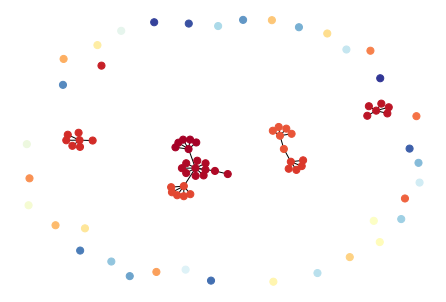

The Modularity of the Community Partitioning is:  0.7717685235262304


In [28]:
# Plot, color nodes using community structure
values = [part.get(node) for node in G.nodes()]
nx.draw_spring(G, cmap=plt.cm.RdYlBu, node_size=50, node_color = values, font_size=12, with_labels=False, font_family='sans-serif')

#nx.draw_spring(G, cmap = plt.get_cmap('jet'), node_color = values, node_size=30, with_labels=False)

#pos = nx.spring_layout(G)  # compute graph layout
#nx.draw_networkx_nodes(G, pos, node_size=30, cmap=plt.cm.RdYlBu, node_color=values)
#nx.draw_networkx_edges(G, pos,edgelist=edge_list, alpha=0.3)

plt.show()

print('The Modularity of the Community Partitioning is: ', community_louvain.modularity(part,G))

In [29]:
graphFile = 'community_detection.graphml'

In [30]:
with open(graphFile, 'wb') as fOut:
    nx.write_graphml(G, fOut)

In [31]:
# read it back in to demonstrate it works
replyGraph = nx.readwrite.read_graphml(graphFile)


# computing the degree centrality and plotting it
lDegCentrality = nx.degree_centrality(replyGraph)


#
# write code to compute eigenvetor and katz centrality
# lEigenVectorCentrality = ...
#
lEigenVectorCentrality = nx.eigenvector_centrality(replyGraph)
lKatzCentrality = nx.katz_centrality(replyGraph)

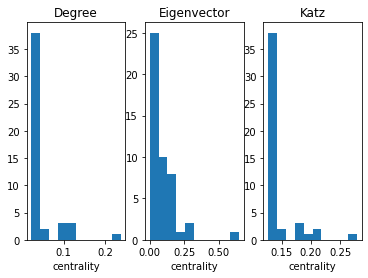

In [32]:
# plot histograms
plt.subplot(1,3,1)
plt.hist(list(lDegCentrality.values()))
plt.title('Degree')
plt.xlabel('centrality')
#
# TODO: plot the other two histograms
#
# eigenvector centrality
plt.subplot(1, 3, 2)
plt.hist(list(lEigenVectorCentrality.values()))
plt.title('Eigenvector')
plt.xlabel('centrality')
# katz centrality
plt.subplot(1, 3, 3)
plt.hist(list(lKatzCentrality.values()))
plt.title('Katz')
plt.xlabel('centrality')

plt.show()

In [ ]:

#
# eigenvector centrality, stored in node attribute 'eigen'
for nodeId, cent in lEigenVectorCentrality.items():
    replyGraph.nodes[nodeId]['eigen'] = float(cent)

# katz centrality, stored in node attribute 'katz'
for nodeId, cent in lKatzCentrality.items():
    replyGraph.nodes[nodeId]['katz'] = float(cent)


#
# TODO: write out graph to new file
#
nx.readwrite.write_graphml(replyGraph, 'mod' + graphFile, infer_numeric_types=True)


#
# TODO: compute the other SNA measures specified in the lab
#

#
# compute clustering
# the networkx code is within format(...)
#
print('Gloabl clustering coefficient/transitivit = {}'.format(nx.transitivity(replyGraph)))


#
# compute components
#
print('number of strongly connected components = {}'.format(nx.number_strongly_connected_components(replyGraph)))
print('number of weakly connected components = {}'.format(nx.number_weakly_connected_components(replyGraph)))



#
# compute bridges
#
print(list(nx.bridges(replyGraph.to_undirected())))
